# Example of the Workflow

This is an example of main.py in the ionic_liquids folder.  I will first have to import the libraries that are necessary to run this program, including train_test_split that allows for splitting datasets into training sets and test sets necessary to run machine learning. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as Calculator
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from numpy import linalg as LA

For this example, I will utilize the following filename, machine learning model, and  directory name to save the model. 

In [2]:
FILENAME = 'inputdata.xlsx'
MODEL = 'mlp_regressor'
DIRNAME = 'my_test'

The following step prepares the data to be read in the machine_learning methods. First, we need to get the data into a readable form and parse, if necessary. In our case, we need to parse the values and errors in the last column of the FILENAME.

In [3]:
def read_data(filename):
    """
    Reads data in from given file to Pandas DataFrame

    Inputs
    -------
    filename : string of path to file

    Returns
    ------
    df : Pandas DataFrame

    """
    cols = filename.split('.')
    name = cols[0]
    filetype = cols[1]
    if (filetype == 'csv'):
        df = pd.read_csv(filename)
    elif (filetype in ['xls', 'xlsx']):
        df = pd.read_excel(filename)
    else:
        raise ValueError('Filetype not supported')

    # clean the data if necessary
    df['EC_value'], df['EC_error'] = zip(*df['ELE_COD'].map(lambda x: x.split('±')))
    y_error = np.copy(df['EC_error'])
    df = df.drop('EC_error', 1)
    df = df.drop('ELE_COD', 1)

    return df, y_error

df, y_error = read_data(FILENAME)


Secondly, we will create a X matrix and y vector that are send to the molecular descriptor function in utils.py. The X matrix will hold all of our inputs for the machine learning whereas y vector will be the actual electronic conductivity values. 

In [5]:
def molecular_descriptors(data):
    """
    Use RDKit to prepare the molecular descriptor

    Inputs
    ------
    data: dataframe, cleaned csv data

    Returns
    ------
    prenorm_X: normalized input features
    Y: experimental electrical conductivity

    """
    
    n = data.shape[0]
    # Choose which molecular descriptor we want
    list_of_descriptors = ['NumHeteroatoms', 'ExactMolWt',
        'NOCount', 'NumHDonors',
        'RingCount', 'NumAromaticRings', 
        'NumSaturatedRings', 'NumAliphaticRings']
    # Get the molecular descriptors and their dimension
    calc = Calculator(list_of_descriptors)
    D = len(list_of_descriptors)
    d = len(list_of_descriptors)*2 + 4

    Y = data['EC_value']
    X = np.zeros((n, d))
    X[:, -3] = data['T']
    X[:, -2] = data['P']
    X[:, -1] = data['MOLFRC_A']
    for i in range(n):
        A = Chem.MolFromSmiles(data['A'][i])
        B = Chem.MolFromSmiles(data['B'][i])
        X[i][:D]    = calc.CalcDescriptors(A)
        X[i][D:2*D] = calc.CalcDescriptors(B)

    prenorm_X = pd.DataFrame(X,columns=['NUM', 'NumHeteroatoms_A', 
        'MolWt_A', 'NOCount_A','NumHDonors_A', 
        'RingCount_A', 'NumAromaticRings_A', 
        'NumSaturatedRings_A',
        'NumAliphaticRings_A', 
        'NumHeteroatoms_B', 'MolWt_B', 
        'NOCount_B', 'NumHDonors_B',
        'RingCount_B', 'NumAromaticRings_B', 
        'NumSaturatedRings_B', 
        'NumAliphaticRings_B',
        'T', 'P', 'MOLFRC_A'])

    prenorm_X = prenorm_X.drop('NumAliphaticRings_A', 1)
    prenorm_X = prenorm_X.drop('NumAliphaticRings_B', 1)

    return prenorm_X, Y 
X, y = molecular_descriptors(df)
y = df['EC_value'].reshape((X.shape[0],1))

/Users/SarahsAdventure/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:55: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


We can prepare our testing and training data set for the machine learning calling using train_test_split, a function called from sklearn module of python. 

In [6]:
X_train,X_test,y_train,y_test,e_train,e_test = train_test_split(X,y,y_error,test_size=0.1)
#X_train,X_test,Y_train,Y_test,e_train,e_test = train_test_split(X,y,y_error, test_size=0.05)

Followingly, the program will normalize the testing data using the training data set. This will also provide us with the mean value and standard deviation of X. 

In [7]:
def normalization(data, means=None, stdevs=None):
    """
    Normalizes the data using the means and standard
    deviations given, calculating them otherwise.
    Returns the means and standard deviations of columns.

    Inputs
    ------
    data : Pandas DataFrame
    means : optional numpy argument of column means
    stdevs : optional numpy argument of column st. devs

    Returns
    ------
    normed : the normalized DataFrame
    means : the numpy row vector of column means
    stdevs : the numpy row vector of column st. devs

    """
    cols = data.columns
    data = data.values

    if (means is None) or (stdevs is None):
        means = np.mean(data, axis=0)
        stdevs = np.std(data, axis=0, ddof=1)
    else:
        means = np.array(means)
        stdevs = np.array(stdevs)

    # handle special case of one row
    if (len(data.shape) == 1) or (data.shape[0] == 1):
        for i in range(len(data)):
            data[i] = (data[i] - means[i]) / stdevs[i]
    else: 
        for i in range(data.shape[1]):
            data[:,i] = (data[:,i] - means[i]*np.ones(data.shape[0])) / stdevs[i]

    normed = pd.DataFrame(data, columns=cols)

    return normed, means, stdevs

X_train, X_mean, X_std = normalization(X_train)

We coded three models into our program:  MLP_regressor, LASSO, and SVR.  Each of these models are  well documented in  sklearn, a library in  python.  *In the actual program, you can use all three models, but for the purpose of this example, we chose mlp_regressor.* The ValueError will only raise if you do not use one of the three models. A good example is if you were to change the MODEL used to 'MLP_classifier'.  

In [16]:
def do_svr(X,y):
    y.ravel()
    """
    Call the Support Vector Regressor, 
    Fit the weight on the training set
    
    Input
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    svr: objective, the regressor objective 
    """
    
    svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001,
        C=1.0, epsilon=0.01, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
    svr = GridSearchCV(svr, cv=5, param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)})
    svr.fit(X,y)
    return svr

def do_MLP_regressor(X,y):
    y.ravel()
    """
    Call the MLP Regressor, 
    Fit the weight on the training set
    
    Input
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    mlp_regr : the MLP object with the best parameters
    """    
    alphas = np.array([5,2,5,1.5,1,0.1,0.01,0.001,0.0001,0])
    mlp_regr = MLPRegressor(hidden_layer_sizes=(100,), activation='tanh',
        solver='sgd', alpha=0.0001, max_iter=5000, random_state=None,learning_rate_init=0.01)
    grid_search = GridSearchCV(mlp_regr, param_grid=dict(alpha=alphas))
    grid_search.fit(X,y)
    
    #print(grid_search.best_params_)
    mlp_regr.alpha_ = grid_search.best_params_['alpha']
    mlp_regr.fit(X,y)

    return mlp_regr

def do_lasso(X,y): 
    y.ravel()
    """
    Runs a lasso grid search on the input data
    
    Inputs
    ------
    X: dataframe, n*m, n is number of data points, 
        m is number of features
    y: experimental electrical conductivity
    
    Returns
    ------
    lasso : sklearn object with the model information 
    """
    
    alphas = np.array([5,4,3,2,1,0.1,0.01,0.001,0.0001])
    lasso = Lasso(alpha=0.001, fit_intercept=True, normalize=False, precompute=False,
        copy_X=True, max_iter=10000, tol=0.001, positive=False, random_state=None, selection='cyclic')
    gs = GridSearchCV(lasso, param_grid=dict(alpha=alphas))
    gs.fit(X,y)
    
    lasso.alpha_ = gs.best_params_['alpha']

    lasso.fit(X,y)
        
    return lasso


In [17]:
if (MODEL.lower() == 'mlp_regressor'):
    obj = do_MLP_regressor(X_train, y_train)
elif (MODEL.lower() == 'lasso'):
    obj = do_lasso(X_train, y_train)
elif (MODEL.lower() == 'svr'):
    obj = do_svr(X_train, y_train)
else:
    raise ValueError("Model not supported")

/Users/SarahsAdventure/miniconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/SarahsAdventure/miniconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/SarahsAdventure/miniconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/SarahsAdventure/miniconda3/lib/python3.5/site-packages/sklearn/neural_network/

After the method is called , it will be saved to an objective.  This objective is saved along with the mean and standard deviation and the training set in the directory, named  DIRNAME. This step is not as important for the workflow but vital to the success of the graphical user interface. 

Lastly, the experimental values will be scatter plotted against the predicted values. We will use the parity_plot to do so. plt.show()  function will just allow the plot to show up. 

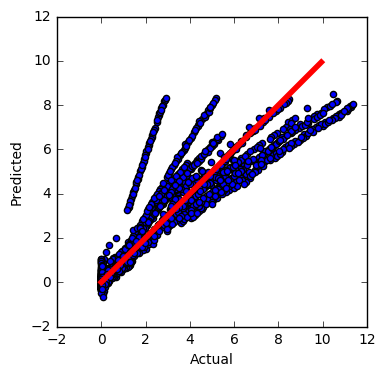

In [18]:
FIG_SIZE = (4,4)

def parity_plot(y_act, y_pred):
    """
    Creates a parity plot

    Input
    -----
    y_pred : predicted values from the model
    y_act : 'true' (actual) values

    Output
    ------
    fig : matplotlib figure

    """

    fig = plt.figure(figsize=FIG_SIZE)
    plt.scatter(list(y_act), list(y_pred))
    plt.plot([y_act.min(), y_act.max()], [y_act.min(), y_act.max()],
             lw=4, color='r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    return fig

my_plot = parity_plot(y_train, obj.predict(X_train))
plt.show(my_plot)

In [19]:
#X = np.genfromtxt('../datasets/Selective_descriptors_X')
#Y = np.genfromtxt('../datasets/Selective_descriptors_Y').reshape((X.shape[0],1))
#Y_error = np.genfromtxt('../datasets/Selective_descriptors_error')

#X = StandardScaler().fit_transform(X)
#X_train,X_test,Y_train,Y_test,e_train,e_test = train_test_split(X,Y,Y_error,test_size=0.10)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(e_train.shape,e_test.shape)

(2270, 18) (253, 18)
(2270, 1) (253, 1)
(2270,) (253,)


In [76]:

#data = read_data(FILENAME)
#df = data[0:1].copy()
#df = pd.to_numeric(df)
#n = df.shape[0]
#X,Y = molecular_descriptors(df)
#print(df)
#Y = df['EC_value']
#Y = Y.values.reshape((X.shape[0],1))
#X_train, X_mean, X_std = normalization(X_train)
#X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size=0.1,random_state=1010)
n_train = X_train.shape[0]
n_test = X_test.shape[0]
d = X_train.shape[1]

hdnode = 100
w1 = np.random.normal(0,0.001,d*hdnode).reshape((d,hdnode))
d1 = np.zeros((d,hdnode))
w2 = np.random.normal(0,0.001,hdnode).reshape((hdnode,1))
d2 = np.zeros(hdnode)
h  = np.zeros(hdnode)

mb = 100 #minibatch size
m = int(n_train/mb)
batch = np.arange(m)
lr = 0.00020
EP = 20000
ep = 0
y = np.zeros((mb,1))
yh = np.zeros((n_train,1))
yh2 = np.zeros((n_test,1))
L_train= np.zeros(EP+1)
L_test = np.zeros(EP+1)

L01_train = np.zeros((EP+1))
L01_test = np.zeros((EP+1))

#tanh
def g(A):
    return (np.tanh(A))

def gd(A):
    return (1-np.square(np.tanh(A)))
    
EP = 20000
ep = 0
print(yh.shape,yh2.shape)
print(X_test.shape,X_train.shape)
print(y_test.shape, y_train.shape )
while ep < EP:
    ep += 1
    print(yh.dtype,y_train.dtype)
    yh = g(X_train.dot(w1)).dot(w2)
    yh2 = g(X_test.dot(w1)).dot(w2)

    L_train[ep] = LA.norm(yh-y_train)/n_train
    L_test[ep]  = LA.norm(yh2-y_test)/n_test
    np.random.shuffle(batch)
    
    for i in range(m):
        st = batch[i]*mb
        ed = (batch[i]+1)*mb

        h  = g(X_train[st:ed].dot(w1))
        y = h.dot(w2)

        d2 = h.T.dot(y_train[st:ed]-y)
        d1 = X_train[st:ed].T.dot(np.multiply((y_train[st:ed]-y).dot(w2.T),gd(X_train[st:ed].dot(w1))))

        w2 += lr*d2
        w1 += lr*d1


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_train,yh,s=0.5,color='blue')
plt.title('Prediction on training data')
plt.plot(np.linspace(0,12,1000),np.linspace(0,12,1000),color='black')
plt.xlim((0,12))
plt.ylim((0,12))
plt.xlabel("Experiment($S*m^2/mol$)")
plt.ylabel("Prediction($S*m^2/mol$)")

plt.subplot(1,2,2)
plt.scatter(y_test,yh2,s=2,color='blue')
plt.title('Prediction on test data')
plt.xlim((0,12))
plt.ylim((0,12))
plt.xlabel("Experiment($S*m^2/mol$)")
plt.ylabel("Prediction($S*m^2/mol$)")
plt.plot(np.linspace(0,12,1000),np.linspace(0,12,1000),color='black')
plt.show()


(2270, 1) (253, 1)
(253, 18) (2270, 18)
(253, 1) (2270, 1)


AttributeError: module 'pandas' has no attribute 'series'

In [ ]:
regr = MLP(solver='sgd',activation='tanh',max_iter=10000000000,learning_rate_init=0.0002,hidden_layer_sizes=(100,),batch_size=100)
regr.fit(X_train,y_train)

result = pd.DataFrame(columns=['Experiment','Prediction','error'])
pd.set_eng_float_format(accuracy=7, use_eng_prefix=True)
result.Experiment = y_train.astype(float)
result.Prediction = regr.predict(X_train)
result.error = e_train.astype(float)
result = result.sort_values(['Experiment','Prediction'],ascending=[1,1])
size=0.2
plt.figure(figsize=(6,4))
plt.scatter(np.arange(X_train.shape[0]),result.Experiment,color="blue",s=size)
plt.scatter(np.arange(X_train.shape[0]),result.Prediction,color="red",s=size)
#print(result.Experiment.dtype, result.error.dtype)
plt.scatter(np.arange(X_train.shape[0]),result.Experiment+result.error,color="green",s=size)
plt.scatter(np.arange(X_train.shape[0]),result.Experiment-result.error,color="green",s=size)
plt.xlim(0,3000
plt.show()

Feel free to look at the other examples that will be more explicit about the functions.  I hope you enjoy our package and use it to fit your needs!